import modules

In [1]:
import sys

sys.path.insert(0, "../../")
sys.path.insert(0, "../../../ABC")
from typing import Tuple
import torch as t
from torch.distributions import uniform, normal
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from model import init_grids, model
from vis_utils import visualize_batch, visualize_sequence
from utils import chop_and_shuffle_data, heaviside, pre_process
from likelihoods import spread_likelihood, transition_likelihood, neg_log_likelihood
from distance_funcs import mean_sq_distance
from helpers import gaussian_pdf
from math import factorial
import time
from IPython.display import Image
from IPython import display
from tqdm import tqdm
from matplotlib import ticker

# Experiment 4: Using Straight-through gradient estimation

## 1. Define the model functions

In [2]:
def model_gumbel(grids: t.Tensor, beta: t.Tensor) -> t.Tensor:
    healthy_mask = 1 - grids
    # calculate the likelihood of spread 
    likelihoods = spread_likelihood(grids, beta)
    #print(likelihoods.flatten().unsqueeze(1).shape)
    flattened = likelihoods.flatten().unsqueeze(0)
    #print(t.concat([t.log(flattened), t.log(1-flattened)], dim=0).T.shape)
    update = t.nn.functional.gumbel_softmax(t.concat([t.log(flattened), t.log(1-flattened)]).T, hard=True)
    #print(update.shape)
    unflattened = update[:,0].unflatten(dim=0, sizes=grids.shape) * healthy_mask
    # apply the update to the current state
    return grids + unflattened

## 2. Dataset generated with a single $\beta$ value

### generate dataset

in this case, we can use the same model for generating the observations as for training. The two are equivalent in regards to the forward pass of the data

In [11]:
grid_size = 80
batch_size = 10
steps_per_sequence = 60
beta = t.tensor(0.05)

framerate = 0.2

In [12]:
print(f"generate dataset with beta={beta}")
sequences = t.zeros((batch_size, steps_per_sequence, grid_size, grid_size))
batch = init_grids(grid_size,batch_size)

for i in range(steps_per_sequence):
  sequences[:,i,:,:] = batch
  batch = model_gumbel(batch, beta)
  
dataset = chop_and_shuffle_data(sequences)
print(dataset.shape)

generate dataset with beta=0.05000000074505806
torch.Size([590, 2, 80, 80])


### visualize example sequence

In [ ]:
grids = init_grids(grid_size, 1)
for i in range(steps_per_sequence):
  fig, axs = plt.subplots(figsize=(3,3), dpi=300)
  axs.imshow(grids[0], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
  axs.get_xaxis().set_visible(False)
  axs.get_yaxis().set_visible(False)
  fig.tight_layout()
  fig.savefig(f"./images/{i}.png")
  #display.display(plt.gcf())
  grids = model_gumbel(grids, beta)
  #display.clear_output(wait=True)

In [7]:
import imageio
images = []
for i in range(steps_per_sequence):
    images.append(imageio.imread(f"./images/{i}.png"))
imageio.mimsave("animation.gif", images)

/tmp/ipykernel_82281/3454463742.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f"./images/{i}.png"))


### pre-process the dataset

In [8]:
dataset = pre_process(dataset)

remove 0 entries from the dataset
torch.Size([590, 2, 80, 80])


### visualize the gradient of the distance function w.r.t. $\beta$ for $\beta=[0,1]$

In [9]:
betas = t.linspace(0.0, 1.0, 1000)
X = dataset[:,0]
Y_obs = dataset[:,1]
grads = []
distances = []
for beta in tqdm(betas):
    beta.requires_grad_()
    Y_sim = model_gumbel(X, beta)
    dist = mean_sq_distance(X, Y_sim, Y_obs)
    distances.append(dist.detach().clone())
    gradient = t.autograd.grad(dist, beta)[0]
    grads.append(gradient.detach().clone())

100%|██████████| 1000/1000 [24:09<00:00,  1.45s/it]


In [10]:
t.save(dataset, "data_singlebeta.pt")
np.save("grads_singlebeta.npy", np.array(grads))
np.save("dist_singlebeta.npy", np.array(distances))

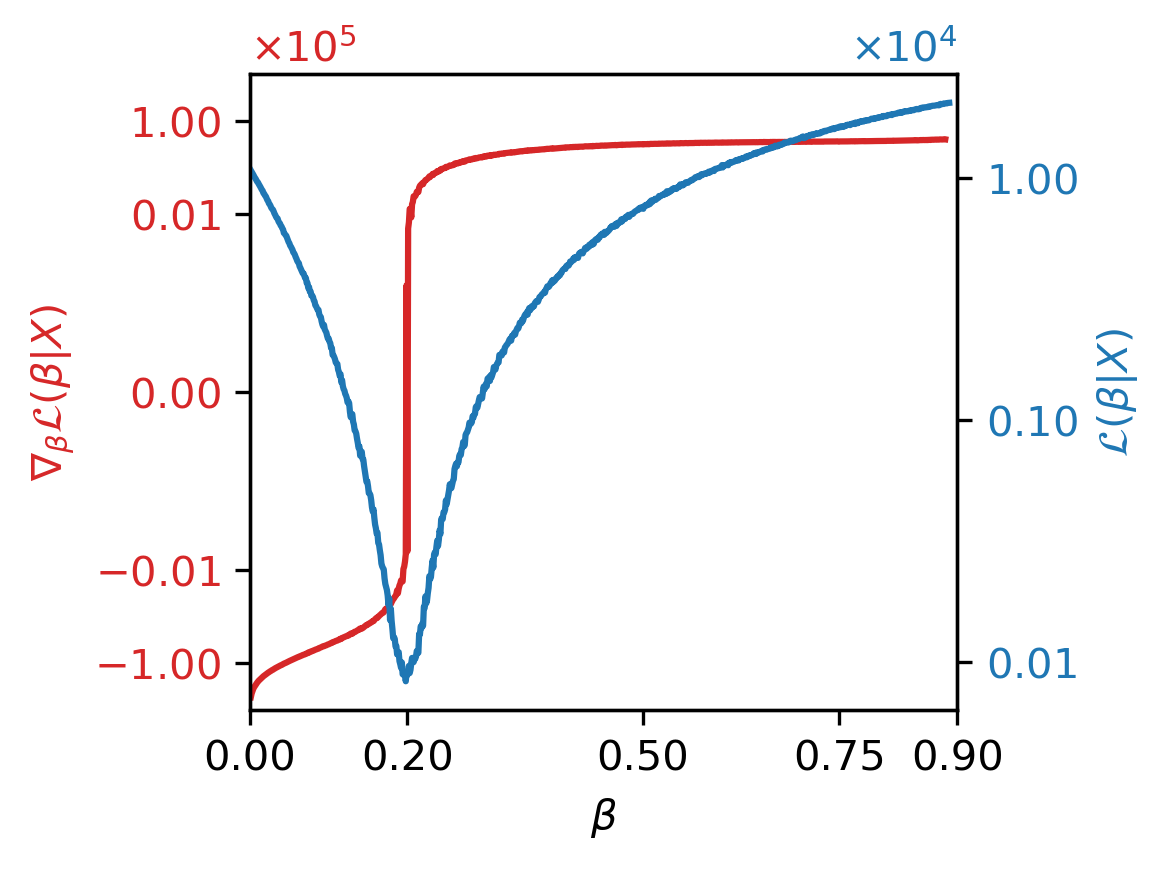

In [113]:
fig, axs = plt.subplots(figsize=(4,3), dpi=300)

color = 'tab:red'
axs.plot(betas, grads, color=color)
axs.set_xlabel("$\\beta$")
axs.set_ylim(-10**6,10**6)
axs.set_ylabel("$\\nabla_{\\beta} \mathcal{L}(\\beta|X)$", color=color)
axs.set_yscale("symlog")
axs.minorticks_off()
axs.tick_params(axis='y', labelcolor=color)
axs.set_xticks([0, 0.2, 0.5, 0.75, 0.9])
base = 10**6
ticks = [-0.1*base, -0.001*base, 0, .001*base, .1*base]
axs.set_yticks(ticks)
axs.set_yticklabels(["$%.3f$" % y for y in ticks])
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
axs.yaxis.set_major_formatter(formatter) 

color = 'tab:blue'
formatter2 = ticker.ScalarFormatter(useMathText=True)
formatter2.set_scientific(True) 
formatter2.set_powerlimits((-1,1)) 
axs2 = axs.twinx()
axs2.set_xlim(0,0.9)
axs2.set_ylabel("$\mathcal{L}(\\beta|X)$", color=color)
axs2.set_yscale("log")
axs2.plot(betas[:890], distances[:890])
axs2.yaxis.set_major_formatter(formatter2) 
axs2.minorticks_off()
axs2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

## 2. Dataset generated from a distribution of $\beta$ values

### create custom torch dataset

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class CustomDataset(Dataset):
    def __init__(self, load_path, beta_mu, beta_sigma, num_sequences, steps_per_sequence, grid_size):
        if load_path:
            self.data = t.load(load_path)
        else:
            sequences = t.zeros((num_sequences, steps_per_sequence, grid_size, grid_size))
            self.betas = []

            for seq_idx in tqdm(range(num_sequences)):
                sequence = init_grids(grid_size,1)
                for step_idx in range(steps_per_sequence):
                    beta = t.clip(normal.Normal(beta_mu, beta_sigma).sample(), 0, 1)
                    sequences[seq_idx,step_idx,:,:] = sequence
                    sequence = model_gumbel(sequence, beta)
                    self.betas.append(beta.detach().cpu())

            dataset = chop_and_shuffle_data(sequences, shuffle=False)
            self.data = pre_process(dataset)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], 0

In [ ]:
training_data = CustomDataset(beta_mu=0.5, beta_sigma=0.1, num_sequences=500, steps_per_sequence=15, grid_size=25)
len(training_data)
training_loader = DataLoader(training_data, batch_size=32, shuffle=True)
t.save(training_data.data, "data_multibeta.pt")

## 3. introduce minibatch SGD 

### define a minibatch training loop

In [26]:
beta = uniform.Uniform(t.tensor(0.), t.tensor(1.)).sample()
beta.requires_grad_()
lr = 1e-7
epochs = 1_000
optimizer = t.optim.SGD([beta], lr=lr)

def train_loop(dataloader, optimizer):
    size = len(dataloader.dataset)
    betas = []
    distances = []
    for batch, (transitions, _) in enumerate(dataloader):
        X = transitions[:, 0]
        Y_obs = transitions[:, 1]
        # Compute prediction and loss
        Y_sim = model_gumbel(X, beta)
        dist = mean_sq_distance(X, Y_sim, Y_obs)
        distances.append(dist.detach().clone().cpu())
        # Backpropagation
        optimizer.zero_grad()
        dist.backward()
        optimizer.step()
        betas.append(beta.detach().clone().cpu())
    return betas, distances

### run the training

In [ ]:
beta_hist = []
dist_hist = []
for epoch in tqdm(range(200)):
    betas, distances = train_loop(training_loader, optimizer)
    #print(betas)
    beta_hist = beta_hist + betas
    dist_hist = dist_hist + distances
print("Done!")

In [30]:
np.save("betas_multibeta_mean0.5.npy" ,np.array(beta_hist))
np.save("dist_multibeta_mean0.5.npy", np.array(dist_hist))

### compare to actual likelihoods

In [78]:
betas = t.linspace(0.4, 0.5, 500)
X = training_loader.dataset[:][0][:,0]
print(X.shape)
Y_obs = training_loader.dataset[:][0][:,1]
likelihoods = []
for beta in tqdm(betas):
    beta.requires_grad_()
    L = spread_likelihood(X, beta)
    P = transition_likelihood(L, X, Y_obs)
    likelihood = neg_log_likelihood(P)
    likelihoods.append(likelihood.detach().clone().cpu())

torch.Size([7000, 25, 25])


100%|██████████| 500/500 [03:00<00:00,  2.77it/s]


In [79]:
np.save("likelihoods_multibeta.npy", np.array(likelihoods))

tensor(199092.7614, dtype=torch.float64)
tensor(0.4864)
tensor(0.4900)


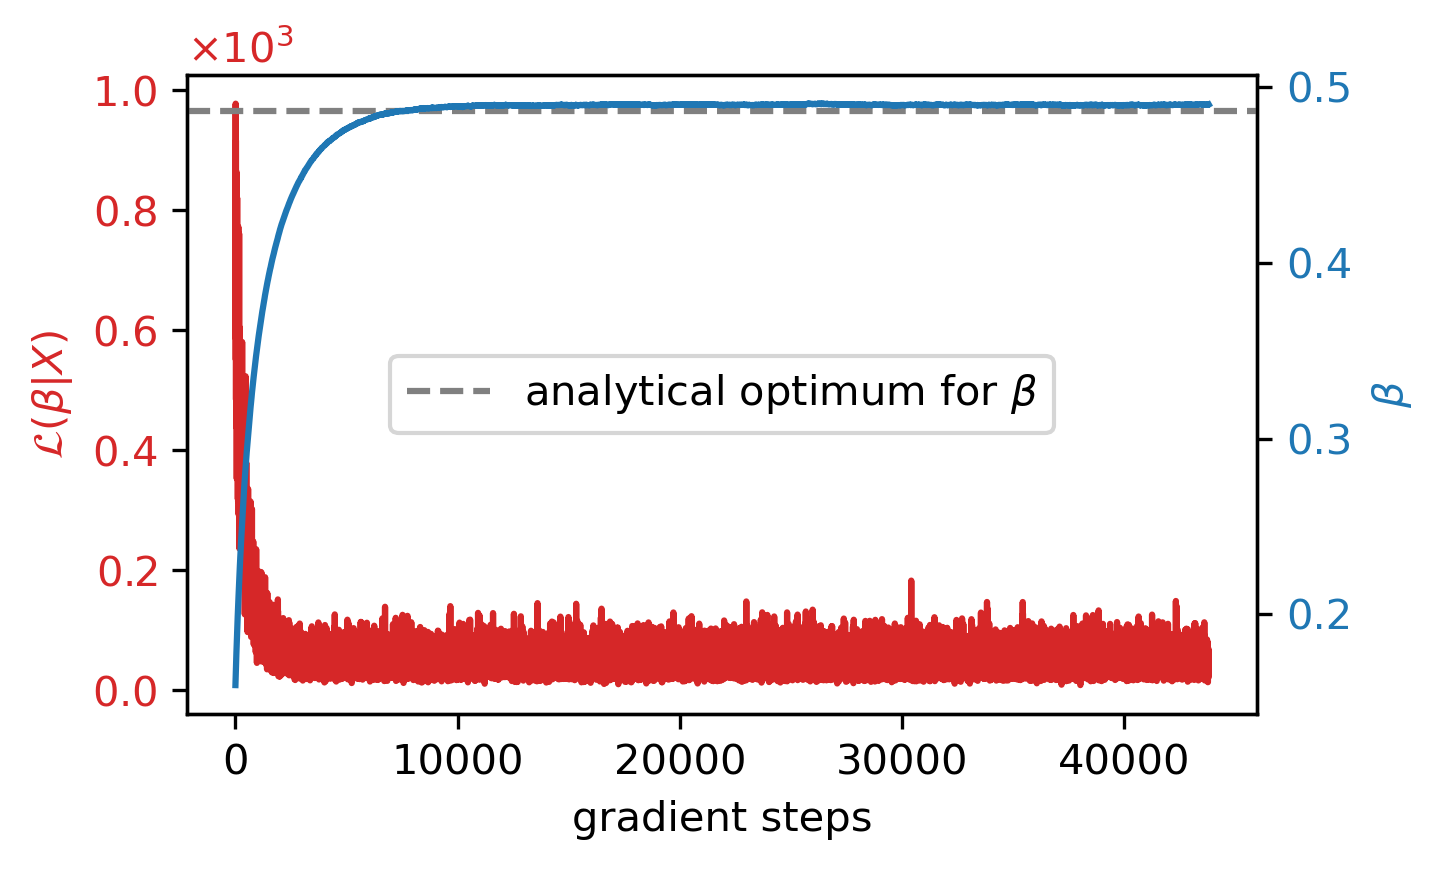

In [88]:
fig, axs = plt.subplots(figsize=(5,3), dpi=300)

axs.set_xlabel("gradient steps")
min_l = min(likelihoods)
print(min_l)
print(betas[likelihoods.index(min_l)])
print(beta_hist[np.argmin(dist_hist)])
#plt.plot(betas.cpu(), t.tensor(likelihoods))
#plt.scatter(betas[likelihoods.index(min_l)].item(), min_l, marker="*")
#print(betas[likelihoods.index(min_l)])
#min_loss = np.min(np.array(dist_hist))
#plt.scatter(beta_hist[np.argmin(np.array(dist_hist))])

color = 'tab:red'
axs.plot(np.arange(len(beta_hist)), np.array(dist_hist), color=color)
axs.set_ylabel("$\mathcal{L}(\\beta|X)$", color=color)
axs.set_yscale("linear")
axs.minorticks_off()
axs.tick_params(axis='y', labelcolor=color)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
axs.yaxis.set_major_formatter(formatter) 

color = 'tab:blue'
axs2 = axs.twinx()
axs2.set_ylabel("$\\beta$", color=color)
axs2.axhline(y=betas[likelihoods.index(min_l)].cpu(), color='gray', linestyle="dashed", label="analytical optimum for $\\beta$")
axs2.plot(np.arange(len(beta_hist)), np.array(beta_hist), color=color)
axs2.tick_params(axis='y', labelcolor=color)

axs2.legend(loc="center")
fig.tight_layout()
plt.show()